# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, I will use a basic Computer Vision technique on an automotive problem. I will teach the caar to detect lane lines, based on just camera data.

**The tools used are are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.** 

The goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below). Once we have a working pipeline, we will try it out on the video stream too.


So let's have a look at our first image called `imgs/test_images/solidWhiteRight.jpg`:

## Import Packages

In [2]:
# import the necessary packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from imutils.paths import list_images
import os
import cv2

# plot inline
%matplotlib inline

## Read in an Image

This image is <class 'numpy.ndarray'> with dimensions (540, 960, 3).


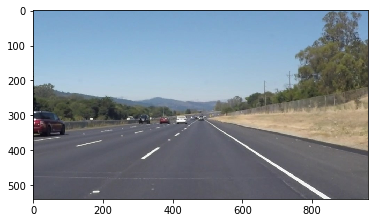

In [3]:
# reading in an image
image = mpimg.imread('imgs/test_images/solidWhiteRight.jpg')

# print out some stats an plot it
print("This image is {} with dimensions {}.".format(type(image), image.shape))
plt.imshow(image)

<p>In this project we should be able to find the lane lanes using only Computer Vision techniques, and you should expect to see this kind of image:</p><br>

<figure>
 <img src="imgs/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> *The output should look something like this after detecting lane lines.*</p> 
 </figcaption>
</figure>

## Helper Functions

Below are some helper functions that will allow us piece together a pipeline to detect the line segments in an given input image.

In [4]:
class Line(object):
    """Create a line from two points.

    Slope-intercept is a specific form of linear equations. It has the following general structure:
    y = mx + b
    where m is the slope of the line and b is the y-intercept.
    Give two points p1=(x1, y1) and p2=(x2, y2), this class creates a Line object and
    calculates its slope and y-intercept.

    Attributes:
        x1: A float x-coordinate for p1.
        y1: A float y-coordinate for p1.
        x2: A float x-coordinate for p2.
        y2: A float y-coordinate for p1.
        slope: A float indicating the slope (gradient) of the line.
        intercept: A float indicating where the line crosses the y-axis (0, b).
    """

    def __init__(self, x1, y1, x2, y2):
        """Inits a Line object for two points coordinates."""
        self.x1 = np.int32(x1)
        self.y1 = np.int32(y1)
        self.x2 = np.int32(x2)
        self.y2 = np.int32(y2)
        self.slope = self.get_slope()
        self.bias = self.get_bias()

    def set_coordinates(self, x1, y1, x2, y2):
        """Set coordinates for a line object."""
        self.x1 = x1
        self.x2 = x2
        self.y1 = y1
        self.y2 = y2

    def get_coordinates(self):
        """Return coordinates for a line object."""
        return np.array([self.x1, self.y1, self.x2, self.y2])

    def get_slope(self):
        """Calculates the slope of a line and return its value."""
        slope = (self.y2 - self.y1) / (self.x2 - self.x1)
        return slope

    def get_bias(self):
        """Returns the bias term for a given line."""
        bias = self.y1 - (self.get_slope() * self.x1)
        return bias

    def draw_line(self, image, color=(255, 0, 0), thickness=3):
        """Draw a line over an image."""
        cv2.line(image, (self.x1, self.y1), (self.x2, self.y2),
                 color, thickness)
        return None

    def __repr__(self):
        return "[({}, {}) ({}, {})]".format(self.x1, self.y1, self.x2, self.y2)

    def __str__(self):
        return "p1: {},{} p2: {},{}".format(self.x1, self.y1, self.x2,self.y2)

In [5]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, kernel_size, 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    # defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    # defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    # filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    # returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)    
    [l.draw_line(line_img) for l in lines]
    
    return line_img


def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, solid_line=True):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len,
                            maxLineGap=max_line_gap)
    detected_lines = [Line(l[0][0], l[0][1], l[0][2], l[0][3]) for l in lines]
    
    return detected_lines

def compute_best_lanes(line_candidates, img):
    """Compute lines for both lanes."""
    
    # get the x and y sizes of the image
    xsize = img.shape[1]
    ysize = img.shape[0]
    
    # find positive and negative slopes that may represent left and right lanes,
    # the find the subset where the slope fits on the input image (range of the slopes)
    pos_lanes = [l for l in line_candidates if l.slope >= 0.5 and l.slope <= 0.9 and l.y1 > ysize // 2 and 
                 l.y2 > ysize // 2]
    neg_lanes = [l for l in line_candidates if l.slope <= -0.5 and l.slope >= -0.9 and l.y1 > ysize // 2 and 
                 l.y2 > ysize // 2]

    
    # compute an equation that approximates left lanes
    neg_slope = np.mean([l.slope for l in neg_lanes])
    neg_bias = np.mean([l.bias for l in neg_lanes]).astype(int)
    x1, y1 = np.int32((ysize - neg_bias) / neg_slope), ysize
    x2, y2 = np.int32(-neg_bias / neg_slope),0
    left_lane = Line(x1, y1, x2, y2)
    
    # compute an equation that approximates right lanes
    pos_slope = np.median([l.slope for l in pos_lanes])
    pos_bias = np.median([l.bias for l in pos_lanes]).astype(int)
    x1, y1 = xsize, np.int32(xsize * pos_slope + pos_bias)
    x2, y2 = 0, pos_bias
    right_lane = Line(x1, y1, x2, y2)
    
    # create a black image with same input image dimensions and draw a solid line on it
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    left_lane.draw_line(line_img)
    right_lane.draw_line(line_img)
        
    return line_img, left_lane, right_lane


def weighted_img(img, initial_img, alpha=0.7, beta=1., gama=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * alpha + img * beta + gama
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, alpha, img, beta, gama)

## 1. Build a Lane Finding Pipeline (images)

In this first step I will build a pipeline that will draw lane lines on the test_images and run it over all images in the directory `imgs/test_images`, then it will save them to the `test_images_output directory`.

In [17]:
## set parameters for helper pipeline
# gaussian blur
kernel_size = (5, 5)    

# canny transform
low_threshold = 50        
high_threshold = 150       

# hough transform
rho = 2
theta = np.pi / 180
threshold = 15
min_line_len = 40
max_line_gap = 20

In [22]:
def process_image(image_path, solid_line=True):
    # read in the image
    image = mpimg.imread(path)
    
    # extract x and y dimensions of the image
    ysize, xsize=image.shape[0:2]
    
    # convert to grayscal
    img_gray = grayscale(image)
    
    # perform gaussian blur
    img_blur = gaussian_blur(img_gray, kernel_size)
    
    # perform edge detection (Canny transform)
    img_edge = canny(img_blur, low_threshold, high_threshold)
    
    # perform line detection (Hough transform)
    lines = hough_lines(img_edge, rho, theta, threshold, min_line_len, max_line_gap)
    
    if solid_line == True:
        img_lines, left_lane, right_lane = compute_best_lanes(lines, image)
    else:
        img_lines = draw_lines(image, lines)

    # mark region of interest only
    vertices = np.array([[(0,ysize),(450, 310), (490, 310), (xsize,ysize)]], dtype=np.int32)
    img_lines = region_of_interest(img_lines, vertices)
        
    # draw lines on the original image
    img_weighted = weighted_img(img_lines, image)
    
    # mark region of interest only
    vertices = np.array([[(0,ysize),(450, 310), (490, 310), (xsize,ysize)]], dtype=np.int32)
    img_lines = region_of_interest(img_lines, vertices)
    
    # draw lines on the original image
    img_weighted = weighted_img(img_lines, image)
    
    # path to output file
    path_split = path.split(os.path.sep)
    output_path = os.path.join(path_split[0], 'test_images_output', path_split[-1])
    
    # save image to output directory
    plt.imsave(output_path, img_weighted)
    
    return img_weighted

#### FInd Lane Lines and plot both original and output images

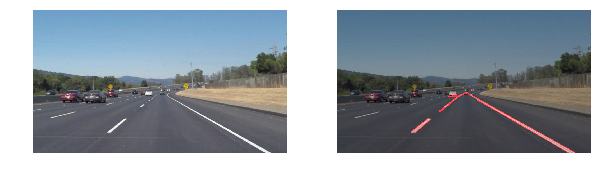

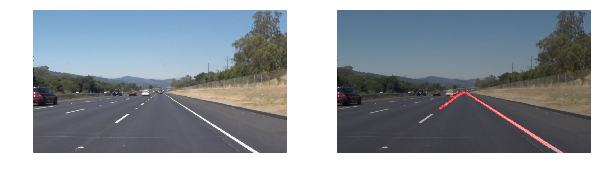

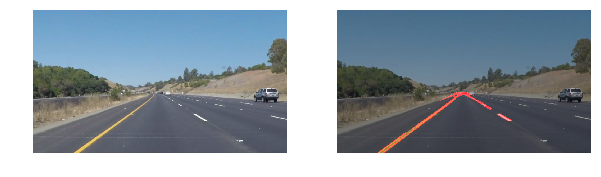

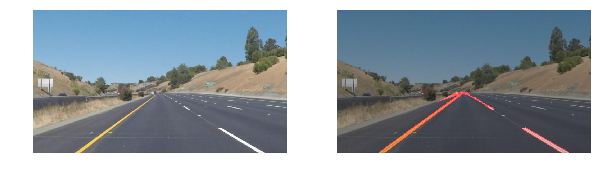

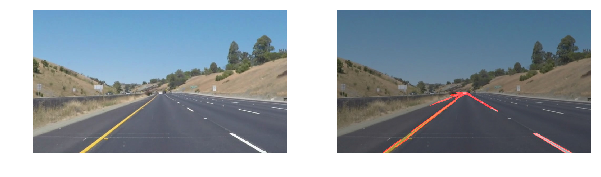

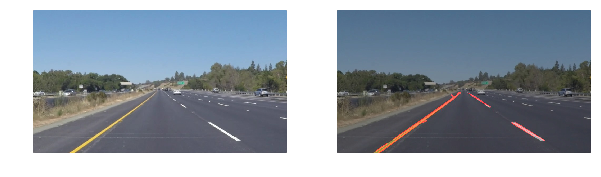

In [50]:
# get image paths for all images inside imgs/test_images
image_paths = list(list_images("imgs/test_images/"))

# iterate over all image on test_images directory and find their lane lines
for i, path in enumerate(image_paths):
    process_image(path, False)
    
# get paths of all output images
output_paths = list(list_images("imgs/test_images_output/"))
num_images = len(image_paths)

# plot original and output side-by-side
for (i, o) in zip(image_paths, output_paths):
    figure = plt.figure(figsize=(10,10))
    i_image = plt.imread(i)
    o_image = plt.imread(o)
    plt.subplot(121)
    plt.imshow(i_image)
    plt.axis('off')
    plt.subplot(122)
    plt.imshow(o_image)
    plt.axis('off')
    plt.show()

## 2. Build a Lane Finding Pipeline (videos)

In this first step I will build a pipeline that will draw lane lines on the test_images and run it over all images in the directory `imgs/test_images`, then it will save them to the `test_images_output directory`.

In [11]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [12]:
def process_image(image, solid_line=True):
    # extract x and y dimensions of the image
    ysize, xsize=image.shape[0:2]
    
    # convert to grayscal
    img_gray = grayscale(image)
    
    # perform gaussian blur
    img_blur = gaussian_blur(img_gray, kernel_size)
    
    # perform edge detection (Canny transform)
    img_edge = canny(img_blur, low_threshold, high_threshold)
    
    # perform line detection (Hough transform)
    lines = hough_lines(img_edge, rho, theta, threshold, min_line_len, max_line_gap)
    
    if solid_line == True:
        img_lines, left_lane, right_lane = compute_best_lanes(lines, image)
    else:
        img_lines = draw_lines(image, lines)

    # mark region of interest only
    vertices = np.array([[(0,ysize),(450, 310), (490, 310), (xsize,ysize)]], dtype=np.int32)
    img_lines = region_of_interest(img_lines, vertices)

    # draw lines on the original image
    img_weighted = weighted_img(img_lines, image)
    
    # mark region of interest only
    vertices = np.array([[(0,ysize),(450, 310), (490, 310), (xsize,ysize)]], dtype=np.int32)
    img_lines = region_of_interest(img_lines, vertices)
    
    # draw lines on the original image
    img_weighted = weighted_img(img_lines, image)
    
    # path to output file
    path_split = path.split(os.path.sep)
    output_path = os.path.join(path_split[0], 'test_images_output', path_split[-1])
    
    # save image to output directory
    # plt.imsave(output_path, img_weighted)
    
    return img_weighted

In [13]:
white_output = 'imgs/test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("imgs/test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video imgs/test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video imgs/test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:03<00:00, 61.42it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: imgs/test_videos_output/solidWhiteRight.mp4 

CPU times: user 2.53 s, sys: 232 ms, total: 2.76 s
Wall time: 3.97 s


In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, we were successful with making the pipeline and tuning parameters. What about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. Let me try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.**

**The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [15]:
yellow_output = 'imgs/test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('imgs/test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video imgs/test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video imgs/test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:11<00:00, 59.22it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: imgs/test_videos_output/solidYellowLeft.mp4 

CPU times: user 7.93 s, sys: 679 ms, total: 8.61 s
Wall time: 11.9 s


In [16]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))